In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from utils import load_all_batches
from itertools import product


# Meine Dataset Klasse
class GasSensorDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, model_dim, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, model_dim)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, model_dim, 2).float() * (-np.log(10000.0) / model_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        # x: (batch_size, seq_len, model_dim)
        x = x + self.pe[:, :x.size(1), :].to(x.device)
        return x

In [4]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, model_dim=64, n_heads=4, num_layers=2, dim_feedforward=128, lr=0.001):
        super(TimeSeriesTransformer, self).__init__()
        self.model_dim = model_dim

        # Pos Encoding
        self.input_proj = nn.Linear(input_dim, model_dim)
        self.pos_encoder = PositionalEncoding(model_dim)

        # Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=n_heads,
            dim_feedforward=dim_feedforward,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Klassifikation
        self.classifier = nn.Linear(model_dim, num_classes)

        # Loss und Optimizer
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1) # Macht eine global avg Pooling über Sequenz
        out = self.classifier(x)
        return out
    
    def train_step(self, batch):
        self.optimizer.zero_grad()
        X_batch, y_batch = batch
        device = next(self.parameters()).device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = self(X_batch)
        loss = self.criterion(outputs, y_batch)
        loss.backward()
        self.optimizer.step()
        return loss.item()


    def test_step(self, batch):
        X_batch, y_batch = batch
        device = next(self.parameters()).device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = self(X_batch)
        loss = self.criterion(outputs, y_batch)
        return loss.item()
        

    def plot_loss(self, train_losses, test_losses):
        epochs = len(train_losses)
        plt.figure(figsize=(8,5))
        plt.plot(range(1, epochs+1), train_losses, marker='o', label="Train Loss")
        plt.plot(range(1, epochs+1), test_losses, marker='o', color='red', label="Test Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Average Loss")
        plt.title("Training vs Test Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

    
    def train_model(self, train_loader, test_loader, epochs):
        all_train_losses = []
        all_test_losses = []
        
        for epoch in range(epochs):
            # Training 
            total_loss = 0
            for batch in train_loader:
                loss = self.train_step(batch)
                total_loss += loss
            avg_train_loss = total_loss / len(train_loader)
            all_train_losses.append(avg_train_loss)
        
            # Testen / Validieren
            total_test_loss = 0
            with torch.no_grad():  # keine Gradienten beim Testen
                for batch in test_loader:
                    loss = self.test_step(batch)  # oder self.train_step(batch) im eval-Modus
                    total_test_loss += loss
            avg_test_loss = total_test_loss / len(test_loader)
            all_test_losses.append(avg_test_loss)
        
            print(f"Epoch [{epoch+1}/{epochs}] | "
                  f"Train Loss: {avg_train_loss:.4f} | "
                  f"Test Loss: {avg_test_loss:.4f}")
        
        self.plot_loss(all_train_losses, all_test_losses)
        
        return all_train_losses, all_test_losses


    def evaluate(self, test_loader):
        self.eval()
        correct, total = 0, 0
        device = next(self.parameters()).device
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = self(X_batch)
                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()
        accuracy = correct / total
        print(f"Test Accuracy: {accuracy:.4f}")
        self.train()
        return accuracy

    def save(self, path):
        torch.save(self.state_dict(), path)
        print(f"Model saved to {path}")

    def load(self, path):
        self.load_state_dict(torch.load(path, map_location=map_location))
        print(f"Model loaded from {path}")

In [5]:
# Datenvorbereitung

folderpath = r"gas+sensor+array+drift+dataset\Dataset"
df = load_all_batches(folderpath)

X = df.iloc[:, 0:128].values
y = df.iloc[:, 128].values

scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


SEQ_LEN = 50

def create_sequences(X, y, seq_len):
    xs, ys = [], []
    for i in range(len(X) - seq_len + 1):
       xs.append(X[i:i+seq_len])
       ys.append(y[i+seq_len-1] - 1)
    return np.array(xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train, y_train, SEQ_LEN)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, SEQ_LEN)

train_dataset = GasSensorDataset(X_train_seq, y_train_seq)
test_dataset = GasSensorDataset(X_test_seq, y_test_seq)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Using device: cuda


C:\Users\volka\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch [1/30] | Train Loss: 1.7795 | Test Loss: 1.7802
Epoch [2/30] | Train Loss: 1.2815 | Test Loss: 0.6672
Epoch [3/30] | Train Loss: 0.5050 | Test Loss: 0.4302
Epoch [4/30] | Train Loss: 0.3413 | Test Loss: 0.3569
Epoch [5/30] | Train Loss: 0.2535 | Test Loss: 0.2224
Epoch [6/30] | Train Loss: 0.1993 | Test Loss: 0.1609
Epoch [7/30] | Train Loss: 0.1600 | Test Loss: 0.1610
Epoch [8/30] | Train Loss: 0.1531 | Test Loss: 0.1279
Epoch [9/30] | Train Loss: 0.1298 | Test Loss: 0.1220
Epoch [10/30] | Train Loss: 0.1369 | Test Loss: 0.1177
Epoch [11/30] | Train Loss: 0.1410 | Test Loss: 0.1132
Epoch [12/30] | Train Loss: 0.1182 | Test Loss: 0.1073
Epoch [13/30] | Train Loss: 0.1097 | Test Loss: 0.1168
Epoch [14/30] | Train Loss: 0.0936 | Test Loss: 0.0935
Epoch [15/30] | Train Loss: 0.0910 | Test Loss: 0.1151
Epoch [16/30] | Train Loss: 0.0922 | Test Loss: 0.1434
Epoch [17/30] | Train Loss: 0.0998 | Test Loss: 0.1195
Epoch [18/30] | Train Loss: 0.0964 | Test Loss: 0.0931
Epoch [19/30] | Tra

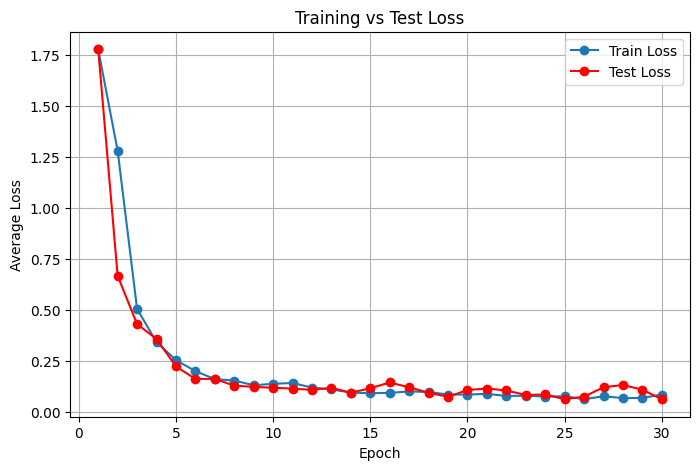

Test Accuracy: 0.9854
Test Accuracy: 0.9854
True: Acetone, Predicted: Acetone
True: Methane, Predicted: Methane
True: Acetone, Predicted: Acetone
True: Toluene, Predicted: Toluene
True: Acetone, Predicted: Acetone
True: Methane, Predicted: Methane
True: Ammonia, Predicted: Ammonia
True: Methane, Predicted: Methane
True: Acetone, Predicted: Acetone
True: Benzene, Predicted: Benzene
True: Toluene, Predicted: Toluene
True: Acetone, Predicted: Acetone
True: Ammonia, Predicted: Ammonia
True: Ammonia, Predicted: Ammonia
True: Acetone, Predicted: Acetone
True: Benzene, Predicted: Acetone
True: Methane, Predicted: Methane
True: Benzene, Predicted: Benzene
True: Methane, Predicted: Methane
True: Acetone, Predicted: Acetone
Model saved to transformer_batch1.pth


In [6]:
# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = TimeSeriesTransformer(input_dim=128, num_classes=6, model_dim=64, n_heads=4, num_layers=2)
model.to(device)

model.train_model(train_loader, test_loader, epochs=30)
model.evaluate(test_loader)


# Vorhersage der Gasarten-Namen
gas_labels = ["Ammonia", "Acetone", "Benzene", "Ethylene", "Methane", "Toluene"]

model.eval()

all_preds = [] # Vorhersagen
all_labels = [] # Echte Labels

with torch.no_grad(): # Schalte Gradient Tracking aus
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Accuracy berechnen
correct = sum(p == t for p, t in zip(all_preds, all_labels))
accuracy = correct / len(all_labels)
print(f"Test Accuracy: {accuracy:.4f}")

for true_idx, pred_idx in zip(all_labels[:20], all_preds[:20]):
    print(f"True: {gas_labels[true_idx]}, Predicted: {gas_labels[pred_idx]}")


model.save("transformer_batch1.pth")


--- Fold 1/5 ---
Epoch [1/30], Loss: 1.7353
Epoch [2/30], Loss: 1.4604
Epoch [3/30], Loss: 1.1365
Epoch [4/30], Loss: 0.8969
Epoch [5/30], Loss: 0.7583
Epoch [6/30], Loss: 0.6405
Epoch [7/30], Loss: 0.5497
Epoch [8/30], Loss: 0.4594
Epoch [9/30], Loss: 0.3747
Epoch [10/30], Loss: 0.3260
Epoch [11/30], Loss: 0.2773
Epoch [12/30], Loss: 0.2365
Epoch [13/30], Loss: 0.2358
Epoch [14/30], Loss: 0.2038
Epoch [15/30], Loss: 0.1847
Epoch [16/30], Loss: 0.1525
Epoch [17/30], Loss: 0.1122
Epoch [18/30], Loss: 0.1064
Epoch [19/30], Loss: 0.0807
Epoch [20/30], Loss: 0.0652
Epoch [21/30], Loss: 0.0583
Epoch [22/30], Loss: 0.0468
Epoch [23/30], Loss: 0.0535
Epoch [24/30], Loss: 0.0644
Epoch [25/30], Loss: 0.0445
Epoch [26/30], Loss: 0.0431
Epoch [27/30], Loss: 0.0374
Epoch [28/30], Loss: 0.0454
Epoch [29/30], Loss: 0.0296
Epoch [30/30], Loss: 0.0287


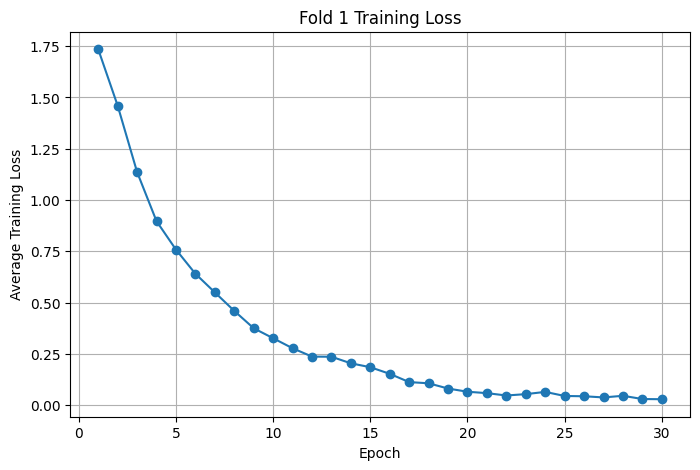

Test Accuracy: 0.9750

--- Fold 2/5 ---
Epoch [1/30], Loss: 1.7200
Epoch [2/30], Loss: 1.4385
Epoch [3/30], Loss: 1.1333
Epoch [4/30], Loss: 0.9323
Epoch [5/30], Loss: 0.7904
Epoch [6/30], Loss: 0.6720
Epoch [7/30], Loss: 0.5586
Epoch [8/30], Loss: 0.4594
Epoch [9/30], Loss: 0.3965
Epoch [10/30], Loss: 0.3359
Epoch [11/30], Loss: 0.3100
Epoch [12/30], Loss: 0.2717
Epoch [13/30], Loss: 0.2356
Epoch [14/30], Loss: 0.1976
Epoch [15/30], Loss: 0.1777
Epoch [16/30], Loss: 0.1595
Epoch [17/30], Loss: 0.1411
Epoch [18/30], Loss: 0.1074
Epoch [19/30], Loss: 0.0892
Epoch [20/30], Loss: 0.0860
Epoch [21/30], Loss: 0.0683
Epoch [22/30], Loss: 0.0585
Epoch [23/30], Loss: 0.0482
Epoch [24/30], Loss: 0.0459
Epoch [25/30], Loss: 0.0356
Epoch [26/30], Loss: 0.0336
Epoch [27/30], Loss: 0.0411
Epoch [28/30], Loss: 0.0341
Epoch [29/30], Loss: 0.0598
Epoch [30/30], Loss: 0.0843


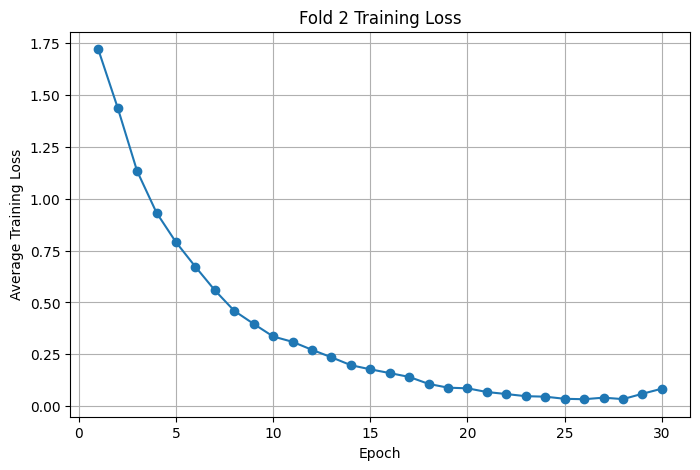

Test Accuracy: 1.0000

--- Fold 3/5 ---
Epoch [1/30], Loss: 1.6135
Epoch [2/30], Loss: 1.2512
Epoch [3/30], Loss: 0.9699
Epoch [4/30], Loss: 0.8030
Epoch [5/30], Loss: 0.6631
Epoch [6/30], Loss: 0.5447
Epoch [7/30], Loss: 0.4733
Epoch [8/30], Loss: 0.3849
Epoch [9/30], Loss: 0.3259
Epoch [10/30], Loss: 0.2986
Epoch [11/30], Loss: 0.2769
Epoch [12/30], Loss: 0.2064
Epoch [13/30], Loss: 0.1764
Epoch [14/30], Loss: 0.1511
Epoch [15/30], Loss: 0.1464
Epoch [16/30], Loss: 0.1325
Epoch [17/30], Loss: 0.1280
Epoch [18/30], Loss: 0.0940
Epoch [19/30], Loss: 0.0768
Epoch [20/30], Loss: 0.0759
Epoch [21/30], Loss: 0.0613
Epoch [22/30], Loss: 0.0437
Epoch [23/30], Loss: 0.0551
Epoch [24/30], Loss: 0.0455
Epoch [25/30], Loss: 0.0425
Epoch [26/30], Loss: 0.0343
Epoch [27/30], Loss: 0.0354
Epoch [28/30], Loss: 0.0398
Epoch [29/30], Loss: 0.0412
Epoch [30/30], Loss: 0.0294


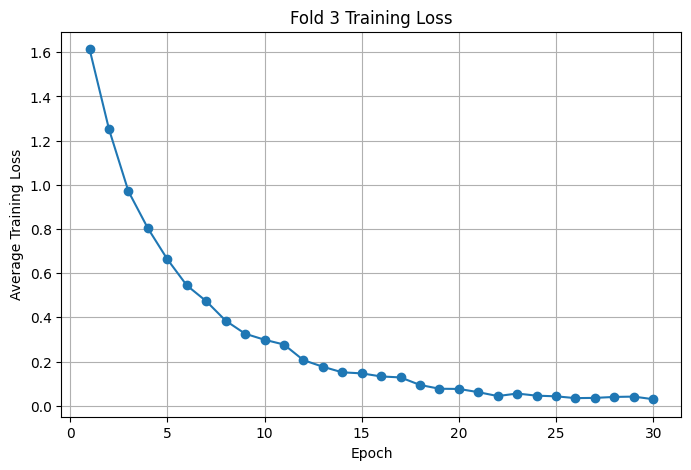

Test Accuracy: 0.9494

--- Fold 4/5 ---
Epoch [1/30], Loss: 1.6931
Epoch [2/30], Loss: 1.2989
Epoch [3/30], Loss: 0.9948
Epoch [4/30], Loss: 0.8027
Epoch [5/30], Loss: 0.6848
Epoch [6/30], Loss: 0.5875
Epoch [7/30], Loss: 0.5096
Epoch [8/30], Loss: 0.4179
Epoch [9/30], Loss: 0.3473
Epoch [10/30], Loss: 0.2994
Epoch [11/30], Loss: 0.2631
Epoch [12/30], Loss: 0.2215
Epoch [13/30], Loss: 0.1974
Epoch [14/30], Loss: 0.1643
Epoch [15/30], Loss: 0.1461
Epoch [16/30], Loss: 0.1239
Epoch [17/30], Loss: 0.1164
Epoch [18/30], Loss: 0.0762
Epoch [19/30], Loss: 0.0785
Epoch [20/30], Loss: 0.0639
Epoch [21/30], Loss: 0.0537
Epoch [22/30], Loss: 0.0521
Epoch [23/30], Loss: 0.0450
Epoch [24/30], Loss: 0.0285
Epoch [25/30], Loss: 0.0338
Epoch [26/30], Loss: 0.0317
Epoch [27/30], Loss: 0.0320
Epoch [28/30], Loss: 0.0228
Epoch [29/30], Loss: 0.0170
Epoch [30/30], Loss: 0.0273


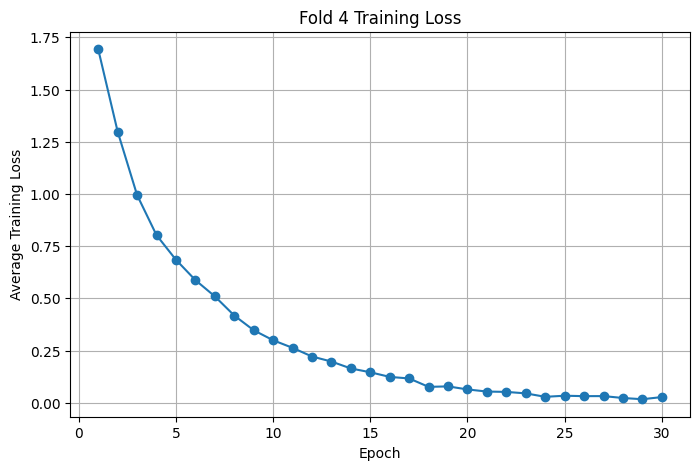

Test Accuracy: 0.9747

--- Fold 5/5 ---
Epoch [1/30], Loss: 1.6737
Epoch [2/30], Loss: 1.3098
Epoch [3/30], Loss: 1.0037
Epoch [4/30], Loss: 0.8223
Epoch [5/30], Loss: 0.6857
Epoch [6/30], Loss: 0.5731
Epoch [7/30], Loss: 0.4857
Epoch [8/30], Loss: 0.4203
Epoch [9/30], Loss: 0.3547
Epoch [10/30], Loss: 0.3038
Epoch [11/30], Loss: 0.2571
Epoch [12/30], Loss: 0.2211
Epoch [13/30], Loss: 0.1890
Epoch [14/30], Loss: 0.1666
Epoch [15/30], Loss: 0.1418
Epoch [16/30], Loss: 0.1249
Epoch [17/30], Loss: 0.1199
Epoch [18/30], Loss: 0.0983
Epoch [19/30], Loss: 0.1052
Epoch [20/30], Loss: 0.0898
Epoch [21/30], Loss: 0.0718
Epoch [22/30], Loss: 0.0602
Epoch [23/30], Loss: 0.0469
Epoch [24/30], Loss: 0.0441
Epoch [25/30], Loss: 0.0366
Epoch [26/30], Loss: 0.0305
Epoch [27/30], Loss: 0.0261
Epoch [28/30], Loss: 0.0226
Epoch [29/30], Loss: 0.0210
Epoch [30/30], Loss: 0.0235


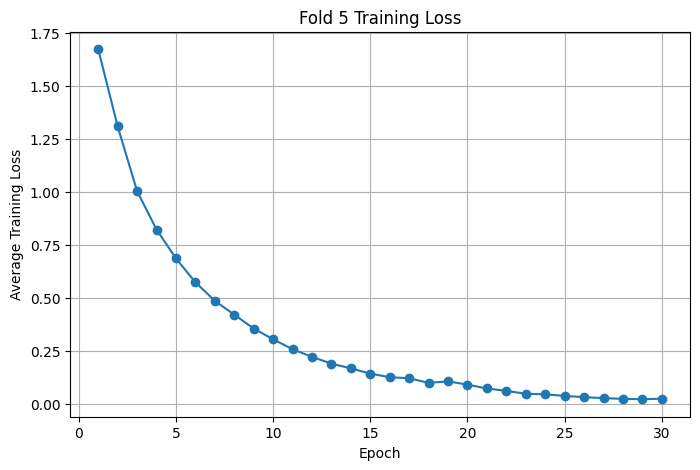

Test Accuracy: 0.9873

Average Accuracy across 5 folds: 0.9773


In [24]:
# NEU: 5-Fold Cross Validation

EPOCHS = 30

# Sequenzen einmal erstellen
X_seq, y_seq = create_sequences(X, y, SEQ_LEN)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_seq)):
    print(f"\n--- Fold {fold+1}/5 ---")
    
    # Fold-Daten
    X_train_fold, y_train_fold = X_seq[train_idx], y_seq[train_idx]
    X_val_fold, y_val_fold = X_seq[val_idx], y_seq[val_idx]
    
    train_dataset = GasSensorDataset(X_train_fold, y_train_fold)
    val_dataset = GasSensorDataset(X_val_fold, y_val_fold)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    
    # Neues Modell pro Fold
    model = TimeSeriesTransformer(input_dim=128, num_classes=6,
                                  model_dim=64, n_heads=4,
                                  num_layers=2, lr=0.001)
    model.to(device)
    
    # Training + Loss speichern
    all_losses = []
    for epoch in range(EPOCHS):
        total_loss = 0
        for batch in train_loader:
            loss = model.train_step(batch)
            total_loss += loss
        avg_loss = total_loss / len(train_loader)
        all_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}")
    
    # Loss-Kurve plotten
    plt.figure(figsize=(8,5))
    plt.plot(range(1, EPOCHS+1), all_losses, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Average Training Loss")
    plt.title(f"Fold {fold+1} Training Loss")
    plt.grid(True)
    plt.show()
    
    # Evaluation 
    acc = model.evaluate(val_loader)
    fold_accuracies.append(acc)

# Durchschnittliche Accuracy der folds
avg_acc = np.mean(fold_accuracies)
print(f"\nAverage Accuracy across 5 folds: {avg_acc:.4f}")


Testing params: n_heads=2, num_layers=1, model_dim=32
Epoch [1/30] | Train Loss: 1.7749 | Test Loss: 1.7757
Epoch [2/30] | Train Loss: 1.7686 | Test Loss: 1.7695
Epoch [3/30] | Train Loss: 1.7701 | Test Loss: 1.7685
Epoch [4/30] | Train Loss: 1.7673 | Test Loss: 1.7663
Epoch [5/30] | Train Loss: 1.7663 | Test Loss: 1.7677
Epoch [6/30] | Train Loss: 1.7664 | Test Loss: 1.7648
Epoch [7/30] | Train Loss: 1.7655 | Test Loss: 1.7723
Epoch [8/30] | Train Loss: 1.7680 | Test Loss: 1.7669
Epoch [9/30] | Train Loss: 1.7652 | Test Loss: 1.7634
Epoch [10/30] | Train Loss: 1.7642 | Test Loss: 1.7643
Epoch [11/30] | Train Loss: 1.7636 | Test Loss: 1.7649
Epoch [12/30] | Train Loss: 1.7632 | Test Loss: 1.7631
Epoch [13/30] | Train Loss: 1.7618 | Test Loss: 1.7602
Epoch [14/30] | Train Loss: 1.7609 | Test Loss: 1.7597
Epoch [15/30] | Train Loss: 1.7425 | Test Loss: 1.5401
Epoch [16/30] | Train Loss: 1.0951 | Test Loss: 0.7819
Epoch [17/30] | Train Loss: 0.6636 | Test Loss: 0.5404
Epoch [18/30] | Tra

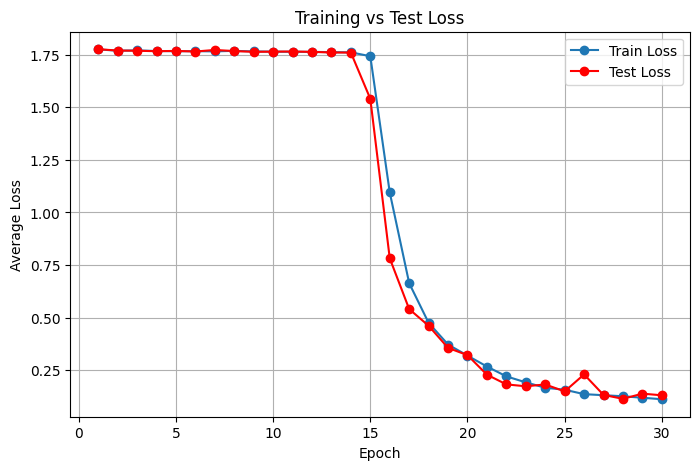

Test Accuracy: 0.9645

Testing params: n_heads=2, num_layers=1, model_dim=64
Epoch [1/30] | Train Loss: 1.7700 | Test Loss: 1.6623
Epoch [2/30] | Train Loss: 1.0396 | Test Loss: 0.6928
Epoch [3/30] | Train Loss: 0.5675 | Test Loss: 0.5272
Epoch [4/30] | Train Loss: 0.4295 | Test Loss: 0.4012
Epoch [5/30] | Train Loss: 0.3706 | Test Loss: 0.3692
Epoch [6/30] | Train Loss: 0.2999 | Test Loss: 0.3951
Epoch [7/30] | Train Loss: 0.2922 | Test Loss: 0.2539
Epoch [8/30] | Train Loss: 0.2508 | Test Loss: 0.2916
Epoch [9/30] | Train Loss: 0.2238 | Test Loss: 0.4046
Epoch [10/30] | Train Loss: 0.2222 | Test Loss: 0.1954
Epoch [11/30] | Train Loss: 0.2030 | Test Loss: 0.3443
Epoch [12/30] | Train Loss: 0.2135 | Test Loss: 0.2067
Epoch [13/30] | Train Loss: 0.1728 | Test Loss: 0.1669
Epoch [14/30] | Train Loss: 0.1652 | Test Loss: 0.2357
Epoch [15/30] | Train Loss: 0.1621 | Test Loss: 0.1597
Epoch [16/30] | Train Loss: 0.1573 | Test Loss: 0.1730
Epoch [17/30] | Train Loss: 0.1592 | Test Loss: 0.19

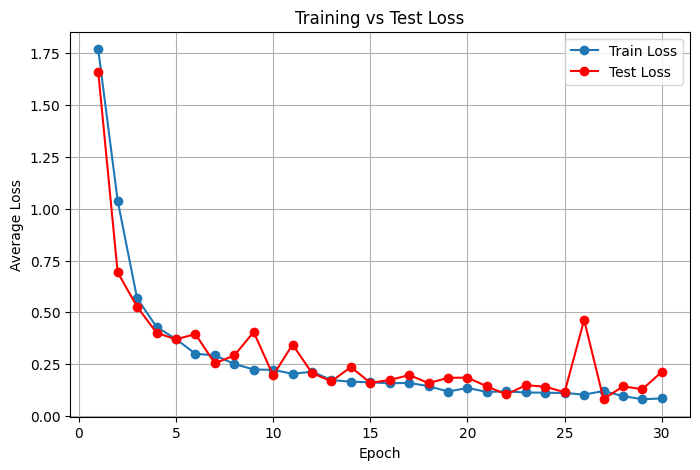

Test Accuracy: 0.9447

Testing params: n_heads=2, num_layers=1, model_dim=128
Epoch [1/30] | Train Loss: 1.4892 | Test Loss: 0.9543
Epoch [2/30] | Train Loss: 0.5042 | Test Loss: 0.4937
Epoch [3/30] | Train Loss: 0.3374 | Test Loss: 0.5438
Epoch [4/30] | Train Loss: 0.2892 | Test Loss: 0.2051
Epoch [5/30] | Train Loss: 0.2295 | Test Loss: 0.2573
Epoch [6/30] | Train Loss: 0.1945 | Test Loss: 0.2577
Epoch [7/30] | Train Loss: 0.1618 | Test Loss: 0.1705
Epoch [8/30] | Train Loss: 0.2178 | Test Loss: 0.1137
Epoch [9/30] | Train Loss: 0.1306 | Test Loss: 0.2403
Epoch [10/30] | Train Loss: 0.1268 | Test Loss: 0.4562
Epoch [11/30] | Train Loss: 0.1419 | Test Loss: 0.1187
Epoch [12/30] | Train Loss: 0.0931 | Test Loss: 0.0721
Epoch [13/30] | Train Loss: 0.1215 | Test Loss: 1.5521
Epoch [14/30] | Train Loss: 0.1840 | Test Loss: 0.0863
Epoch [15/30] | Train Loss: 0.0922 | Test Loss: 0.1449
Epoch [16/30] | Train Loss: 0.0839 | Test Loss: 0.1346
Epoch [17/30] | Train Loss: 0.1026 | Test Loss: 0.2

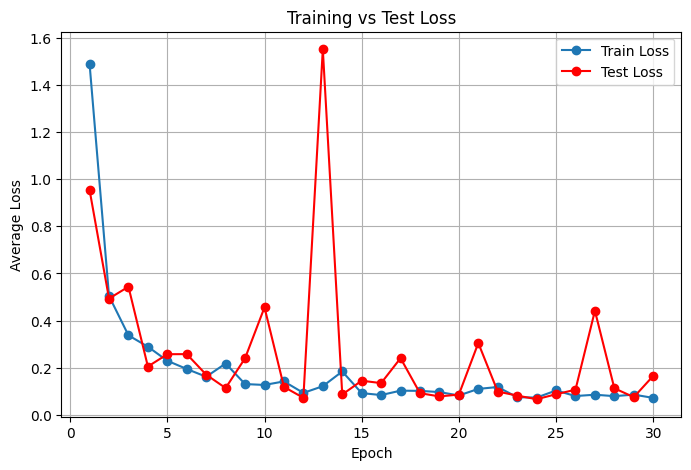

Test Accuracy: 0.9422

Testing params: n_heads=2, num_layers=1, model_dim=256
Epoch [1/30] | Train Loss: 1.4811 | Test Loss: 0.8751
Epoch [2/30] | Train Loss: 0.5367 | Test Loss: 1.2049
Epoch [3/30] | Train Loss: 0.3685 | Test Loss: 0.4748
Epoch [4/30] | Train Loss: 0.2550 | Test Loss: 0.3373
Epoch [5/30] | Train Loss: 0.1983 | Test Loss: 0.3395
Epoch [6/30] | Train Loss: 0.2217 | Test Loss: 0.2871
Epoch [7/30] | Train Loss: 0.1909 | Test Loss: 0.2305
Epoch [8/30] | Train Loss: 0.1273 | Test Loss: 0.1053
Epoch [9/30] | Train Loss: 0.1248 | Test Loss: 0.1846
Epoch [10/30] | Train Loss: 0.1435 | Test Loss: 1.2523
Epoch [11/30] | Train Loss: 0.1836 | Test Loss: 0.1161
Epoch [12/30] | Train Loss: 0.1065 | Test Loss: 0.0853
Epoch [13/30] | Train Loss: 0.1321 | Test Loss: 0.5854
Epoch [14/30] | Train Loss: 0.1126 | Test Loss: 0.7182
Epoch [15/30] | Train Loss: 0.1957 | Test Loss: 0.0693
Epoch [16/30] | Train Loss: 0.0804 | Test Loss: 0.1227
Epoch [17/30] | Train Loss: 0.0768 | Test Loss: 0.0

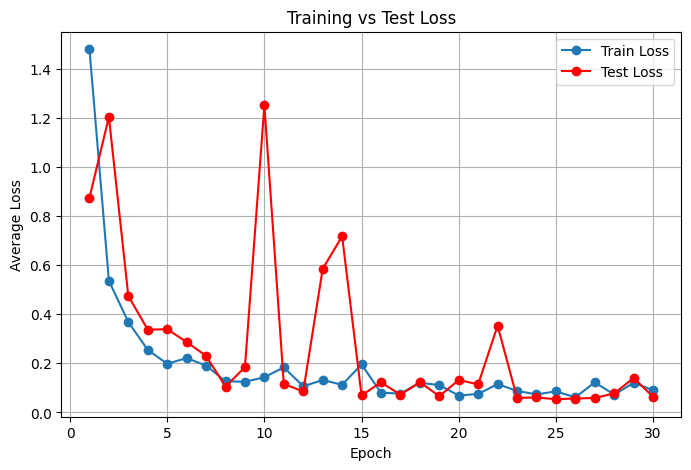

Test Accuracy: 0.9835

Testing params: n_heads=2, num_layers=1, model_dim=512
Epoch [1/30] | Train Loss: 1.5510 | Test Loss: 1.0279
Epoch [2/30] | Train Loss: 0.6884 | Test Loss: 0.7623
Epoch [3/30] | Train Loss: 0.3454 | Test Loss: 0.5855
Epoch [4/30] | Train Loss: 0.3540 | Test Loss: 0.2459
Epoch [5/30] | Train Loss: 0.2635 | Test Loss: 0.4243
Epoch [6/30] | Train Loss: 0.2439 | Test Loss: 0.1761
Epoch [7/30] | Train Loss: 0.1786 | Test Loss: 0.2103
Epoch [8/30] | Train Loss: 0.2419 | Test Loss: 0.3811
Epoch [9/30] | Train Loss: 0.1809 | Test Loss: 0.1465
Epoch [10/30] | Train Loss: 0.1623 | Test Loss: 0.1111
Epoch [11/30] | Train Loss: 0.1488 | Test Loss: 0.8398
Epoch [12/30] | Train Loss: 0.2200 | Test Loss: 0.3816
Epoch [13/30] | Train Loss: 0.1724 | Test Loss: 0.0954
Epoch [14/30] | Train Loss: 0.1218 | Test Loss: 0.1556
Epoch [15/30] | Train Loss: 0.1512 | Test Loss: 0.1670
Epoch [16/30] | Train Loss: 0.1402 | Test Loss: 0.1671
Epoch [17/30] | Train Loss: 0.1366 | Test Loss: 0.1

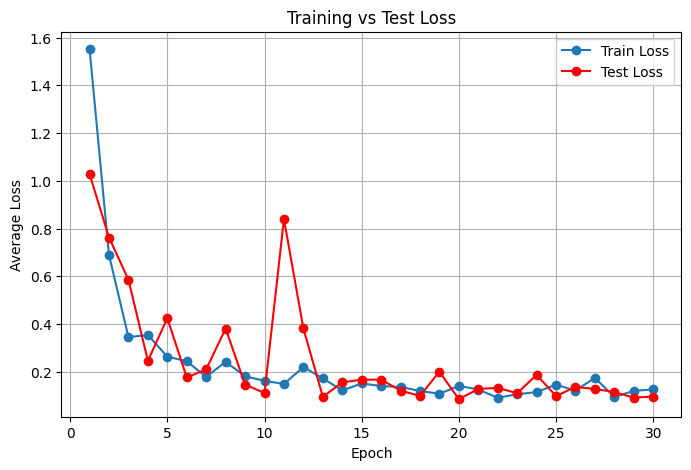

Test Accuracy: 0.9759

Testing params: n_heads=2, num_layers=2, model_dim=32
Epoch [1/30] | Train Loss: 1.7758 | Test Loss: 1.7681
Epoch [2/30] | Train Loss: 1.7661 | Test Loss: 1.7267
Epoch [3/30] | Train Loss: 1.2975 | Test Loss: 1.0424
Epoch [4/30] | Train Loss: 0.9122 | Test Loss: 0.7495
Epoch [5/30] | Train Loss: 0.6970 | Test Loss: 0.5436
Epoch [6/30] | Train Loss: 0.4911 | Test Loss: 0.8424
Epoch [7/30] | Train Loss: 0.4356 | Test Loss: 0.3289
Epoch [8/30] | Train Loss: 0.3391 | Test Loss: 0.2920
Epoch [9/30] | Train Loss: 0.3006 | Test Loss: 0.3710
Epoch [10/30] | Train Loss: 0.2692 | Test Loss: 0.2326
Epoch [11/30] | Train Loss: 0.2647 | Test Loss: 0.2563
Epoch [12/30] | Train Loss: 0.2330 | Test Loss: 0.6989
Epoch [13/30] | Train Loss: 0.2250 | Test Loss: 0.8661
Epoch [14/30] | Train Loss: 0.2741 | Test Loss: 0.2456
Epoch [15/30] | Train Loss: 0.2269 | Test Loss: 0.2107
Epoch [16/30] | Train Loss: 0.1867 | Test Loss: 0.9403
Epoch [17/30] | Train Loss: 0.2264 | Test Loss: 0.35

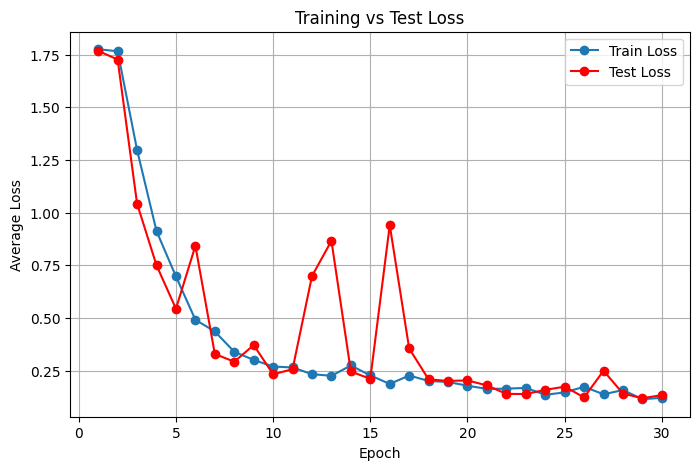

Test Accuracy: 0.9693

Testing params: n_heads=2, num_layers=2, model_dim=64
Epoch [1/30] | Train Loss: 1.7542 | Test Loss: 1.5482
Epoch [2/30] | Train Loss: 1.0759 | Test Loss: 0.7494
Epoch [3/30] | Train Loss: 0.6600 | Test Loss: 0.5330
Epoch [4/30] | Train Loss: 0.4582 | Test Loss: 0.5361
Epoch [5/30] | Train Loss: 0.3636 | Test Loss: 0.2576
Epoch [6/30] | Train Loss: 0.2886 | Test Loss: 0.2261
Epoch [7/30] | Train Loss: 0.2690 | Test Loss: 0.8589
Epoch [8/30] | Train Loss: 0.2418 | Test Loss: 0.2323
Epoch [9/30] | Train Loss: 0.2091 | Test Loss: 0.7552
Epoch [10/30] | Train Loss: 0.3814 | Test Loss: 0.3278
Epoch [11/30] | Train Loss: 0.1938 | Test Loss: 0.2202
Epoch [12/30] | Train Loss: 0.1662 | Test Loss: 0.3424
Epoch [13/30] | Train Loss: 0.1474 | Test Loss: 0.1150
Epoch [14/30] | Train Loss: 0.1458 | Test Loss: 0.1101
Epoch [15/30] | Train Loss: 0.1454 | Test Loss: 0.1239
Epoch [16/30] | Train Loss: 0.1113 | Test Loss: 0.2472
Epoch [17/30] | Train Loss: 0.1286 | Test Loss: 0.10

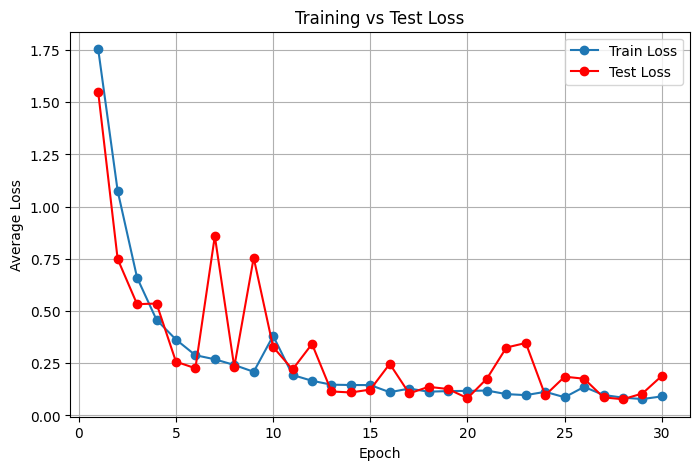

Test Accuracy: 0.9393

Testing params: n_heads=2, num_layers=2, model_dim=128
Epoch [1/30] | Train Loss: 1.5415 | Test Loss: 0.7940
Epoch [2/30] | Train Loss: 0.5088 | Test Loss: 0.5002
Epoch [3/30] | Train Loss: 0.3290 | Test Loss: 0.2723
Epoch [4/30] | Train Loss: 0.2222 | Test Loss: 0.3379
Epoch [5/30] | Train Loss: 0.1732 | Test Loss: 0.2226
Epoch [6/30] | Train Loss: 0.1657 | Test Loss: 0.1696
Epoch [7/30] | Train Loss: 0.1354 | Test Loss: 0.2819
Epoch [8/30] | Train Loss: 0.1605 | Test Loss: 0.1150
Epoch [9/30] | Train Loss: 0.1043 | Test Loss: 0.1313
Epoch [10/30] | Train Loss: 0.1098 | Test Loss: 0.1273
Epoch [11/30] | Train Loss: 0.0986 | Test Loss: 0.0911
Epoch [12/30] | Train Loss: 0.1006 | Test Loss: 0.2266
Epoch [13/30] | Train Loss: 0.1058 | Test Loss: 0.0755
Epoch [14/30] | Train Loss: 0.0941 | Test Loss: 0.0792
Epoch [15/30] | Train Loss: 0.0763 | Test Loss: 0.1060
Epoch [16/30] | Train Loss: 0.0834 | Test Loss: 0.2620
Epoch [17/30] | Train Loss: 0.0922 | Test Loss: 0.0

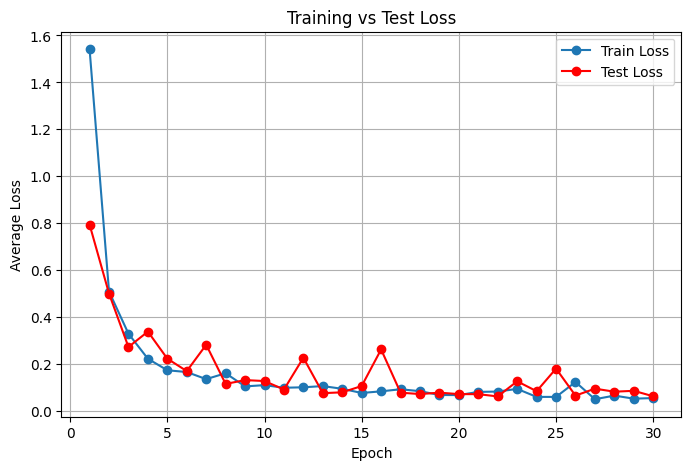

Test Accuracy: 0.9821

Testing params: n_heads=2, num_layers=2, model_dim=256
Epoch [1/30] | Train Loss: 1.5260 | Test Loss: 1.2256
Epoch [2/30] | Train Loss: 0.6933 | Test Loss: 0.6213
Epoch [3/30] | Train Loss: 0.3743 | Test Loss: 0.3629
Epoch [4/30] | Train Loss: 0.3094 | Test Loss: 1.7163
Epoch [5/30] | Train Loss: 0.4494 | Test Loss: 0.5015
Epoch [6/30] | Train Loss: 0.2782 | Test Loss: 0.2591
Epoch [7/30] | Train Loss: 0.2475 | Test Loss: 0.6816
Epoch [8/30] | Train Loss: 0.2328 | Test Loss: 0.1441
Epoch [9/30] | Train Loss: 0.1798 | Test Loss: 0.2319
Epoch [10/30] | Train Loss: 0.2248 | Test Loss: 0.3493
Epoch [11/30] | Train Loss: 0.2096 | Test Loss: 0.3449
Epoch [12/30] | Train Loss: 0.5297 | Test Loss: 0.3359
Epoch [13/30] | Train Loss: 0.4103 | Test Loss: 0.3260
Epoch [14/30] | Train Loss: 0.3421 | Test Loss: 0.2212
Epoch [15/30] | Train Loss: 0.3238 | Test Loss: 0.6283
Epoch [16/30] | Train Loss: 0.2220 | Test Loss: 0.1608
Epoch [17/30] | Train Loss: 0.2317 | Test Loss: 0.5

KeyboardInterrupt: 

In [10]:
# ---- GRID SEARCH ----

params = {
    "n_heads": [2, 4, 8, 16],  # Es muss gelten model_dim % n_heads = 0 
    "num_layers": [1, 2, 3, 4],
    "model_dim": [32, 64, 128, 256]
}

param_combi = list(product(
    params["n_heads"],
    params["num_layers"],
    params["model_dim"]
))

results = []

for n_heads, num_layers, model_dim in param_combi:
    print(f"\nTesting params: n_heads={n_heads}, num_layers={num_layers}, model_dim={model_dim}")

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    model = TimeSeriesTransformer(input_dim=128, num_classes=6, model_dim=model_dim, n_heads=n_heads, num_layers=num_layers)
    model.train_model(train_loader, test_loader, epochs=30)

    acc = model.evaluate(test_loader)
    results.append((n_heads, num_layers, model_dim, acc))
    torch.cuda.empty_cache()

best = max(results, key=lambda x: x[-1])
print("\nBeste Hyperparameter-Kombination: ", best)